In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append(os.path.abspath("../.."))  # Adds the project root to sys.path
import numpy as np 
import math
import tensorflow as tf

from recommenders.datasets.linear_regression import *

In [2]:
save_interaction_values()

[47608, 52026, 54268, 55284]


In [2]:
Y, R, num_products = get_data()

Y (117, 4) R (117, 4)
num_products 117
num_users 4


In [5]:
# my_ratings = np.zeros(num_products)

# my_ratings[0] = 5 # Bosch, Burgija
# my_ratings[1] = 1 # Bosch, Testera
# my_ratings[2] = 1 # Bosch, Testera

# # Add new user ratings to Y 
# Y = np.c_[my_ratings, Y]

# # Add new user indicator matrix to R
# R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset


In [4]:
# test_recency_bonus(100, 20)

In [ ]:
num_users = Y.shape[1] # FT: It's mandatory because we could add one more user to the matrix

X, W, b = initialize_tf_variables(num_users, num_products)

Training loss at iteration 0: 12303.99286180866
Training loss at iteration 20: 1454.4401290083763
Training loss at iteration 40: 355.2765502446987
Training loss at iteration 60: 115.10076243097946
Training loss at iteration 80: 48.277222590046826
Training loss at iteration 100: 24.76577887005789
Training loss at iteration 120: 14.564222532701637
Training loss at iteration 140: 9.338472121684006
Training loss at iteration 160: 6.305307860320608
Training loss at iteration 180: 4.387843064392234
Training loss at iteration 200: 3.1131403570364724
Training loss at iteration 220: 2.2456665736960972
Training loss at iteration 240: 1.651341865831542
Training loss at iteration 260: 1.2447987704284673
Training loss at iteration 280: 0.9679730730779669
Training loss at iteration 300: 0.7803293809941774
Training loss at iteration 320: 0.6535240792737004
Training loss at iteration 340: 0.567917913854395
Training loss at iteration 360: 0.510050977406359
Training loss at iteration 380: 0.470784406216

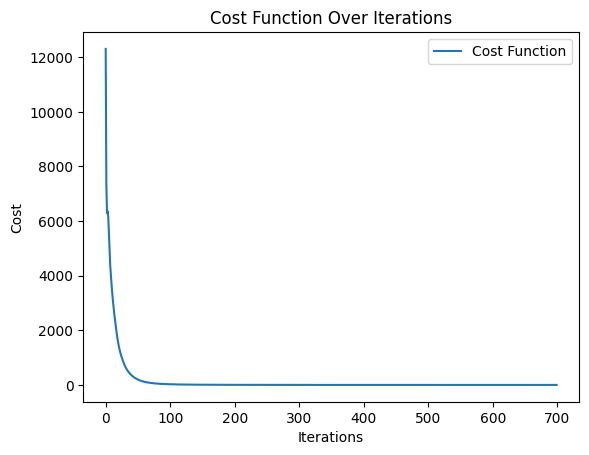

In [ ]:
Ynorm, Ymean = normalize_ratings(Y, R) # FT: Even if it's implicit feedback recommender, some users generate significantly more interactions than others.
calculate_parameters(X, W, b, Ynorm, R, iterations=700, lambda_=1, learning_rate=0.1)

In [ ]:
# product_names = load_csv_list('../../recommenders/datasets/pa/product_names.csv')

# Make a prediction using trained weights and biases
predictions_normalized = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

#restore the mean
predictions = predictions_normalized + Ymean

rmse(Y, predictions, R)

my_predictions = predictions[:,0]

# sort predictions
ix = tf.argsort(my_predictions, direction='DESCENDING')

# Get the top 10 indices
top_10_ix = ix[:10]

# Get the top 10 values
top_10_predictions = tf.gather(my_predictions, top_10_ix)

# Print results
print("Top 10 predictions:", top_10_predictions.numpy())
print("Indices of top 10 predictions:", top_10_ix.numpy())

# for i in range(len(my_predictions)):
    # print(f'Predict: {my_predictions[i]:0.5f}, Original: {Y[i,0]:0.5f}')
    # if my_ratings[i] > 0:
    #     print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {product_names[i]}')



RMSE score: 0.07748613276423218
Top 10 predictions: [1.01442776 1.01440774 0.97233606 0.78913829 0.78913706 0.7888774
 0.75091111 0.75091079 0.75091033 0.75088427]
Indices of top 10 predictions: [111 110 107  24  23  11  33  30  34  17]


In [4]:
test_recency_bonus(50, 0.1, 20)

Day 1: 0.0951
Day 2: 0.0905
Day 3: 0.0861
Day 4: 0.0819
Day 5: 0.0779
Day 6: 0.0741
Day 7: 0.0705
Day 8: 0.0670
Day 9: 0.0638
Day 10: 0.0607
Day 11: 0.0577
Day 12: 0.0549
Day 13: 0.0522
Day 14: 0.0497
Day 15: 0.0472
Day 16: 0.0449
Day 17: 0.0427
Day 18: 0.0407
Day 19: 0.0387
Day 20: 0.0368
Day 21: 0.0350
Day 22: 0.0333
Day 23: 0.0317
Day 24: 0.0301
Day 25: 0.0287
Day 26: 0.0273
Day 27: 0.0259
Day 28: 0.0247
Day 29: 0.0235
Day 30: 0.0223
Day 31: 0.0212
Day 32: 0.0202
Day 33: 0.0192
Day 34: 0.0183
Day 35: 0.0174
Day 36: 0.0165
Day 37: 0.0157
Day 38: 0.0150
Day 39: 0.0142
Day 40: 0.0135
Day 41: 0.0129
Day 42: 0.0122
Day 43: 0.0116
Day 44: 0.0111
Day 45: 0.0105
Day 46: 0.0100
Day 47: 0.0095
Day 48: 0.0091
Day 49: 0.0086


In [2]:
get_multiple_interaction_bonus(2, 0.2)

0.1542064049718821

In [6]:
get_multiple_interaction_bonus(3, 5)

0.975609756097561